In [104]:
from src.tools import MMSeqs, NCBIDatasets, Prodigal
import pandas as pd
import numpy as np
from src.files import XMLFile, InterProScanFile, FASTAFile, GBFFFile
from utils import * 
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
from src.classifier import Classifier
from src.sampler import Sampler
from src.dataset import Dataset, update, build
import torch
import seaborn as sns 
import re
from tqdm import tqdm
from src.clusterer import Clusterer
from sklearn.decomposition import PCA 

%load_ext autoreload 
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
cluster_df = pd.read_csv('../data/campylobacterota_dataset_labeled_cluster.csv', index_col=0)
cluster_df[clust]

In [177]:
spurious_dataset = Dataset.from_hdf('../data/campylobacterota_dataset_spurious.h5', feature_type='esm_650m_gap')

clusterer = Clusterer(radius=0.1, min_samples=10)
clusterer.fit(spurious_dataset)

spurious_df = pd.read_csv('../data/campylobacterota_dataset_spurious.csv', index_col=0)
spurious_df['cluster_label'] = spurious_df.index.map(clusterer.cluster_map)

clusterer.n_clusters


load_hdf: Reading HDF file from ../data/campylobacterota_dataset_spurious.h5: 100%|██████████| 3/3 [00:00<00:00, 589.09it/s]


173

In [ ]:
embeddings = spurious_dataset.embedding# .to(torch.float16)
dists = torch.cdist(embeddings, embeddings, p=2).numpy() #  compute_mode='donot_use_mm_for_euclid_dist'
np.fill_diagonal(dists, np.inf)
min_dists = dists.min(axis=1)

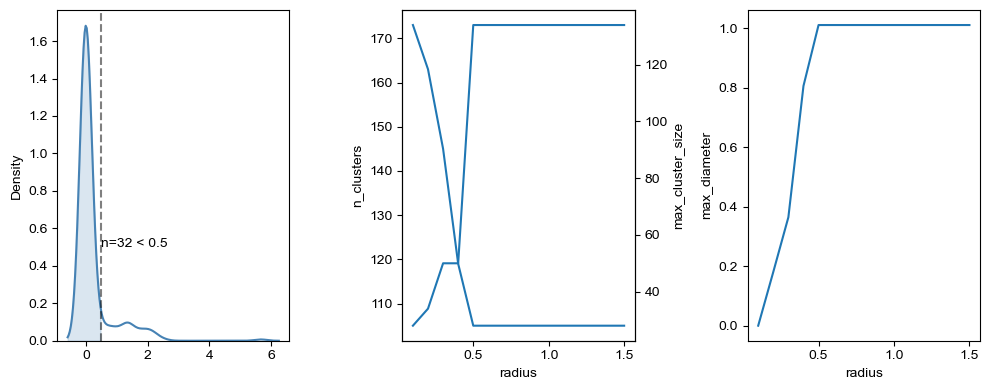

In [175]:
fig, axes = plt.subplots(ncols=3, figsize=(10, 4), layout='tight')

ax_df = list()
for radius in np.linspace(0.1, 1.5, 15):
    clusterer = Clusterer(radius=radius, min_samples=10)
    clusterer.fit(spurious_dataset)

    row = dict()
    row['n_clusters'] = clusterer.n_clusters
    row['max_diameter'] = max(list(clusterer.diameters.values()))
    row['max_cluster_size'] = max([len(cluster) for cluster in clusterer.clusters.values()])
    row['radius'] = radius
    ax_df.append(row)
ax_df = pd.DataFrame(ax_df)

ax = axes[0]
threshold = 0.5
sns.kdeplot(ax=ax, x=min_dists, color='steelblue')
x, y = ax.lines[0].get_xydata().T
ax.axvline(x=threshold, linestyle='--', color='black', alpha=0.5)
mask = x < threshold
ax.fill_between(x[mask], y[mask], alpha=0.2, color='steelblue')
ax.text(threshold, 0.5, f'n={mask.sum()} < {threshold}')

ax = axes[1]
sns.lineplot(ax=ax, data=ax_df, x='radius', y='n_clusters')
sns.lineplot(ax=ax.twinx(), data=ax_df, x='radius', y='max_cluster_size')

ax = axes[2]
sns.lineplot(ax=axes[2], data=ax_df, x='radius', y='max_diameter')

plt.show()

In [ ]:
# df = pd.read_csv('../data/campylobacterota_dataset.csv', index_col=0)
# subset_df = df[df.label == 'spurious'].copy()
# subset_df = pd.concat([subset_df, df[df.label == 'real'].sample(5000 - len(subset_df), replace=False)])

# print('Number of labeled spurious sequences in subset:', (subset_df.label == 'spurious').sum())
# print('Number of labeled real sequences in subset:', (subset_df.label == 'real').sum())

# subset_df.to_csv('../data/campylobacterota_dataset_subset.csv')
# subset_df = pd.read_csv('../data/campylobacterota_dataset_subset.csv', index_col=0)

Number of labeled spurious sequences in subset: 297
Number of labeled real sequences in subset: 4703


In [ ]:
# mmseqs = MMseqs()
# path = mmseqs.align(subset_df, job_name='campylobacterota_dataset_subset', sensitivity=10, max_e_value=10)

MMseqs._make_database: Creating database campylobacterota_dataset_subset_database in ../data/mmseqs/campylobacterota_dataset_subset_database
MMseqs.align: Running alignment on query database campylobacterota_dataset_subset_database.


In [ ]:
# subset_dataset = Dataset.from_hdf('../data/campylobacterota_dataset_subset.h5', feature_type='esm_650m_gap', attrs=['label', 'genome_id'])
# embeddings = subset_dataset.embedding.to(torch.float16)
# dists = torch.cdist(embeddings, embeddings, p=2)
# dist_df = pd.DataFrame(dists, index=subset_dataset.index, columns=subset_dataset.index)
# dist_df.to_csv('../data/campylobacterota_dataset_subset_dists.csv')

In [124]:
dist_df = pd.read_csv('../data/campylobacterota_dataset_subset_dists.csv', index_col=0)

# Convert the alignment data to a distance matrix. 
align_df = MMseqs.load_align('../data/campylobacterota_dataset_subset_align.tsv')
seq_id_df = pd.DataFrame(index=dist_df.index, columns=dist_df.columns) 
for row in tqdm(align_df.itertuples(), total=len(align_df)):
    seq_id_df.loc[row.Index, row.subject_id] = row.sequence_identity

with pd.option_context('future.no_silent_downcasting', True):
    seq_id_df = seq_id_df.fillna(0.0)


100%|██████████| 146808/146808 [00:06<00:00, 23193.06it/s]


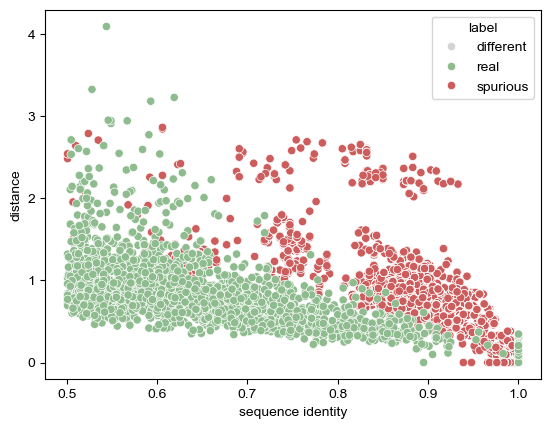

In [178]:
def figure(subset_df, seq_id_df, dist_df, n:int=1000, min_sequence_identity:float=0.5):
    fig, ax = plt.subplots()

    seq_id_arr = np.tril(seq_id_df) # Avoid plotting the same pair twice. 
    dist_arr = np.tril(dist_df) # Avoid plotting the same pair twice. 
    n = dist_df.shape[0]

    labels = np.tile(subset_df.label.values, (n, 1))
    labels = np.where(labels == labels.T, labels, 'different') # Mark locations where the labels are different. 
    
    ax_df = dict()
    ax_df['label'] = labels[seq_id_arr > min_sequence_identity]
    ax_df['sequence_identity'] = seq_id_arr[seq_id_arr > min_sequence_identity]
    ax_df['distance'] = dist_arr[seq_id_arr > min_sequence_identity]

    hue_order = ['different', 'real', 'spurious']
    colors = {'real':'darkseagreen', 'spurious':'indianred', 'different':'lightgray'}
    sns.scatterplot(data=ax_df, x='sequence_identity', y='distance', hue='label', hue_order=hue_order, palette=colors, ax=ax)
    sns.move_legend(ax, loc='upper right')

    ax.set_xlabel('sequence identity')
    ax.set_ylabel('distance')

    plt.show()

figure(subset_df, seq_id_df, dist_df)

# I am clustering at 50 percent similarity, so no two non-spurious sequences have higher than 50 percent identity. 

# What if we take a look at how sequence identity between two real sequences correlates to the distance of the nearest spurious sequence. 

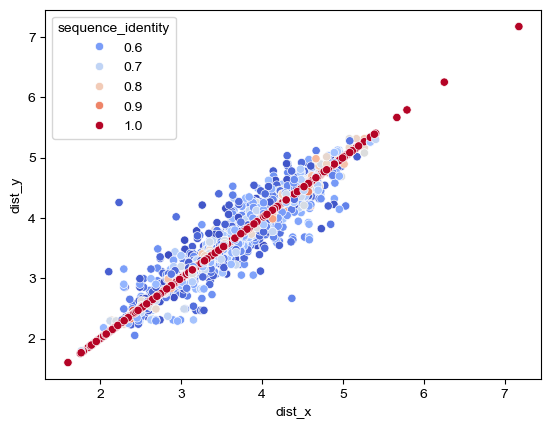

In [155]:
def figure(subset_df, seq_id_df, dist_df, min_sequence_identity:float=0.5):
    fig, ax = plt.subplots()

    labels = subset_df.label.values 

    subset_df = subset_df[labels == 'real'].copy()
    ids = subset_df.index
    
    min_dist_to_spurious = dist_df.loc[labels == 'real', labels == 'spurious'].min(axis=1)
    mean_dist_to_spurious = dist_df.loc[labels == 'real', labels == 'spurious'].mean(axis=1)
    
    seq_ids = seq_id_df.loc[ids, ids].values
    # np.fill_diagonal(seq_ids, 0)
    seq_ids = np.tril(seq_ids, k=0)
    seq_id_df = pd.DataFrame(seq_ids, index=ids, columns=ids)
    idxs = np.where(seq_id_df.values > min_sequence_identity)

    ax_df = pd.DataFrame()
    ax_df['dist_x'] = min_dist_to_spurious.values[idxs[0]]
    ax_df['dist_y'] = min_dist_to_spurious.values[idxs[1]]
    ax_df['sequence_identity'] = seq_ids[idxs] # .ravel()
    sns.scatterplot(data=ax_df, x='dist_x', y='dist_y', color='darkgray', ax=ax, palette='coolwarm', hue='sequence_identity')
    
    plt.show()


figure(subset_df, seq_id_df, dist_df)

In [178]:
# Want to take a look at the cluster size distributions. 
cluster_df = pd.read_csv('../data/campylobacterota_dataset_labeled_cluster.csv', index_col=0)
dataset_df = pd.read_csv('../data/campylobacterota_dataset_labeled.csv', index_col=0)
dataset_df[dataset_df.label == 0].to_csv('../data/campylobacterota_dataset_spurious.csv')
dataset_df = dataset_df.merge(cluster_df, left_index=True, right_index=True)

# # ax_df = pd.DataFrame()
# # ax_df['genome_size'] = dataset_df.groupby('genome_id').apply(len)
# # ax_df['n_clusters'] = dataset_df.groupby('genome_id').cluster_label.nunique()

# ax_df = pd.DataFrame()
# ax_df['cluster_size'] = dataset_df.groupby('cluster_label').apply(len, include_groups=True)
# ax_df['label'] = dataset_df.groupby('cluster_label').label.first()

# fig, ax = plt.subplots()

# print(len(dataset_df[dataset_df.label == 0].drop_duplicates('cluster_label', keep='first')))

# # sns.scatterplot(data=ax_df, x='genome_size', y='n_clusters', ax=ax)

# sns.kdeplot(data=ax_df, x='cluster_size', hue='label', ax=ax, common_norm=False)

In [179]:
dataset_df[dataset_df.label == 0].cluster_label.nunique()

180

In [13]:
# ncbi_genome_metadata_df = load_ncbi_genome_metadata()

# fig, (ax_a, ax_b) = plt.subplots(ncols=2, figsize=(2 * 6.2, 4.8), width_ratios=[0.4, 0.6])

# counts, bins, _ = ax_a.hist(ncbi_genome_metadata_df.gc_percent, bins=25, width=2, edgecolor='black', color='lightgray')
# ax_a.set_ylabel('density')
# ax_a.set_xlabel('GC percent')

# level = 'phylum'
# y = ncbi_genome_metadata_df.groupby(level).gc_percent.mean().values # .sort_values(ascending=True)
# x = ncbi_genome_metadata_df.groupby(level).apply(len, include_groups=False).values # .sort_values(ascending=True)
# y_err = ncbi_genome_metadata_df.groupby(level).apply(lambda df : df.gc_percent.std() / np.sqrt(len(df)), include_groups=False) # .loc[y.index]
# ax_b.errorbar(x, y, yerr=y_err, ls='', lw=0.7, capsize=2, color='black')
# ax_b.scatter(x, y, color='black', s=5)

# phyla = ncbi_genome_metadata_df.groupby(level).first().index
# ax_b.scatter(x[phyla == 'Campylobacterota'], y[phyla == 'Campylobacterota'], facecolor='none',linewidths=1.5, edgecolors='seagreen', s=100, zorder=1000)
# ax_b.scatter(x[phyla == 'Planctomycetota'], y[phyla == 'Planctomycetota'], facecolor='none', linewidths=1.5, edgecolors='seagreen', s=100, zorder=1000)
# ax_b.scatter(x[phyla == 'Deinococcota'], y[phyla == 'Deinococcota'], facecolor='none', linewidths=1.5, edgecolors='seagreen', s=100, zorder=1000)

# ax_b.set_xscale('log')
# ax_b.set_xlabel(f'log({level} size)')
# ax_b.set_ylabel('GC percent')

# plt.show()

In [3]:
# # Start by selecting a few phyla in a reasonable size range with varying GC contents.
# def sample(genome_metadata_df:pd.DataFrame, min_phylum_size:int=90, max_phylum_size:int=200):

#     phylum_sizes = genome_metadata_df.groupby('phylum').apply(len, include_groups=False)
#     phylum_sizes = phylum_sizes[(phylum_sizes > min_phylum_size) & (phylum_sizes < max_phylum_size)]

#     genome_metadata_df = genome_metadata_df[genome_metadata_df.phylum.isin(phylum_sizes.index)]
    
#     phylum_gc_percent = genome_metadata_df.groupby('phylum').gc_percent.mean() 
#     phylum_gc_percent = phylum_gc_percent.sort_values(ascending=True)
    
#     phyla = dict()
#     phyla['low_gc_content'] = phylum_gc_percent.index[0]
#     phyla['med_gc_content'] = phylum_gc_percent.index[len(phylum_gc_percent) // 2]
#     phyla['high_gc_content'] = phylum_gc_percent.index[-1]

#     print('Low-GC content phylum:', phyla['low_gc_content'])
#     print('Medium-GC content phylum:', phyla['med_gc_content'])
#     print('High-GC content phylum:', phyla['high_gc_content'])

#     genome_ids = {category:genome_metadata_df.index[genome_metadata_df.phylum == phylum] for category, phylum in phyla.items()}
#     return genome_ids

# genome_ids = sample(ncbi_genome_metadata_df)

# ncbi = NCBIDatasets(genome_dir='../data/genomes', gbff_dir='../data/proteins/ncbi')
# ncbi.run(genome_ids=genome_ids['low_gc_content'], metadata_only=False)

In [5]:
# genome_metadata_df = list()
# for category, genome_ids_ in genome_ids.items():
#     df = ncbi_genome_metadata_df.loc[genome_ids_, :].copy()
#     df['gc_percent_category'] = category
#     genome_metadata_df.append(df)
# genome_metadata_df = pd.concat(genome_metadata_df)
# genome_metadata_df.to_csv('../data/genome_metadata.csv')

In [ ]:
# genome_metadata_df = pd.read_csv('../data/genome_metadata.csv', index_col=0)
# genome_metadata_df = genome_metadata_df[genome_metadata_df.annotation_pipeline.str.contains('PGAP')]
# campylobacterota_genome_ids = genome_metadata_df[genome_metadata_df.phylum == 'Campylobacterota'].index

# build(campylobacterota_genome_ids, labeled=True, output_path='../data/campylobacterota_dataset_labeled.csv', max_length=2000)
# build(campylobacterota_genome_ids, labeled=False, output_path='../data/campylobacterota_dataset.csv', max_length=2000)

array([1, 0])

In [6]:
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import balanced_accuracy_score
# from sklearn.preprocessing import StandardScaler

# class BenchmarkClassifier():

#     def __init__(self, feature_col:str='query_length'):

#         self.model = LogisticRegression(class_weight='balanced', C=1) # , multi_class='multinomial') 
#         self.scaler = StandardScaler()
#         self.feature_col = feature_col

#     def predict(self, df:pd.DataFrame, include_outputs:bool=True):
#         X = df[[self.feature_col]].values
#         X = self.scaler.transform(X)
#         model_labels = self.model.predict(X)
#         model_outputs = self.model.predict_proba(X)

#         return model_labels if (not include_outputs) else (model_labels, model_outputs)

#     def fit(self, df:pd.DataFrame):
#         X, labels = df[[self.feature_col]].values, df['label'].values
#         X = self.scaler.fit_transform(X)
#         self.model.fit(X, labels)

# model = BenchmarkClassifier()
# model.fit(train_df)

# df = test_df[['label', 'query_length']].copy()
# df['model_label'], outputs = model.predict(test_df, include_outputs=True)
# df['model_output_0'], df['model_output_1'] = outputs[:, 0].ravel(), outputs[:, 1].ravel()

# print('Balanced accuracy:', balanced_accuracy_score(df.label.values, df.model_label.values))
# print('Precision (class 0):', precision(df, class_=0))
# print('Recall (class 0):', recall(df, class_=0))
# print('Number of false negatives:', ((df.label == 1) & (df.model_label == 0)).sum())


# confusion_matrix = np.where((df.model_label == 1) & (df.label == 0), 'false positive', '')
# confusion_matrix = np.where((df.model_label  == 1) & (df.label == 1), 'true positive', confusion_matrix)
# confusion_matrix = np.where((df.model_label == 0) & (df.label == 1), 'false negative', confusion_matrix)
# confusion_matrix = np.where((df.model_label  == 0) & (df.label == 0), 'true negative', confusion_matrix)
# df['confusion_matrix'] = confusion_matrix

# benchmark_fn = df[df.confusion_matrix == 'false negative'].index
# fn = pred_df[pred_df.confusion_matrix == 'false negative'].index
# np.intersect1d(fn, benchmark_fn)

In [ ]:
# There still seems to be something wrong with the training data, perhaps I am still misclassifying the spurious sequences?
# It is possible my "in-frame" check is wrong, it's possible I should only see if either edge is a multiple of 3 base pairs away, 
# as opposed to both.

# It seems as though 684 of the sequences flagged as spurious have an overlap length of 0, so maybe I should be counting those as intergenic?
# Ok, so I think because of how frequent gene overlap is, I should be allowing some (considering genes with less than a certain amount of overlap to be intergenic)
# I should also be very conservative, i.e. allow a comparatively large amount of overlap. 
# https://pmc.ncbi.nlm.nih.gov/articles/PMC525685/ 
